In [5]:
!pip install torch
!pip install matplotlib
!pip install numpy
!pip install kagglehub

  Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_universal2.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached numpy-2.3.0-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_universal2.whl (2.7 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached numpy-2

In [3]:
import torch.nn.functional as F
from torch.distributions import Uniform
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import torch
import os
%matplotlib inline

/Users/ryanmangeno/Documents/dev/ai-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def download_dataset() -> str:
    path = kagglehub.dataset_download("rishitjakharia/names-txt")
    return path # for easier access later

In [6]:
dataset_path = download_dataset() + "/names.txt"

In [7]:
words = open(dataset_path, 'r').read().splitlines()

In [8]:
def make_int_char_maps() -> tuple[dict, dict]:
  chars = sorted(list(set(''.join(words))))
  ctoi = {c: i + 1 for i, c in enumerate(chars)}
  ctoi['.'] = 0
  itoc = {i: c for c, i in ctoi.items()}
  return ctoi, itoc

In [9]:
ctoi, itoc = make_int_char_maps()

In [10]:
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [11]:
print(ctoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [12]:
vocab_size = len(ctoi)
print(vocab_size)

27


In [79]:
block_size = 8
def build_dataset(inp_words) -> tuple[torch.tensor, torch.tensor]:
  inp, target = [], []
  for w in inp_words: 
    context = [0] * block_size

    for ch in w + '.':
      ix = ctoi[ch]
      inp.append(context)
      target.append(ix)
      context = context[1:] + [ix] # crop and append

  inp = torch.tensor(inp)
  target = torch.tensor(target)
  return inp, target

In [80]:
import random
random.seed(42)

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [81]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itoc[ix.item()] for ix in x), '-->', itoc[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [82]:

class Linear:

  def __init__(self, fan_in, fan_out, bias=True, init_mode='kaiming'):
    init_mode = init_mode.lower()
    if init_mode == 'kaiming':
      self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #
      self.bias = torch.zeros(fan_out) if bias else None
    elif init_mode == 'xavier':
      distr = torch.sqrt(6 / (fan_in + fan_out)) # -x to x
      uniform_dist = Uniform(-distr, distr)
      self.weight = uniform_dist.sample(fan_in, fan_out)
      self.bias = torch.zeros(fan_out) if bias else None
    elif init_mode == 'glorot':
      fan_avg = (fan_in + fan_out)/2
      distr = torch.sqrt(3/fan_avg)
      uniform_dist = (-distr, distr)
      self.weight = uniform_dist.sample(fan_in, fan_out)
      self.bias = torch.zeros(fan_out) if bias else None
      
      
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance, mean of 0, variance of 1
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]
  
# -----------------------------------------------------------------------------------------------
class Flatten:

  def __call__(self, x):
    s = x.shape[0]
    x = x.view(s, -1)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [83]:
torch.manual_seed(42) # for reproducibility

In [ ]:
no_init = torch.randn(100, 200)
xav = Linear(100, 200, 'xavier')
kai = Linear(100, 200, 'kaiming')
glor = Linear(100, 200, 'glorot')

In [ ]:
plt.plot(no_init); # comparing different inits

In [ ]:
plt.plot(xav.weight);

In [ ]:
plt.plot(kai.weight);

In [ ]:
plt.plot(glor.weight);

In [352]:
n_emb = 28 # dimensionality of the character vectors
n_hidden = 128 # num hidden layer neurons

C = torch.randn((vocab_size, n_emb))
model=Sequential([
    Embedding(vocab_size, n_emb), 
    FlattenConsecutive(2), Linear(n_emb * 2, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# make the last layer less confident
with torch.no_grad():
    model.layers[-1].weight *= 0.1

params = model.parameters()
print(f"Num Params: {sum(p.nelement() for p in params)}")
for param in params:
    param.requires_grad = True

Num Params: 77711


In [354]:
# we have 8 chars
# 1 2 3 4 5 6 7 8

# (for wavenet) we want to group them by two first 
# (1 2) (3 4) (5 6) (7 8)
# rather than mushing them together in one matrix mult operation with the embeddings

In [355]:
e = torch.randn(4, 8, 10) 
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
implicit = e.view(4, 4, 20) 
torch.equal(explicit, implicit)

True

In [356]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
Xb

tensor([[ 0,  0,  0,  0, 10,  5, 26,  5],
        [ 0,  0,  4, 15, 14,  4, 18,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 21, 20, 19]])

In [357]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 28)
FlattenConsecutive : (4, 4, 56)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [358]:
lossi = []
num_epochs = 200_000
batch_size = 32

In [359]:
for i in range(num_epochs):

    ixs = torch.randint(0, Xtr.shape[0], (batch_size,))
    Yb = Ytr[ixs]
    Xb = Xtr[ixs]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in params:
        p.grad = None
    loss.backward()

    lossi.append(loss.item())

    lr = 0.1
    if i > 125_000:
        lr = 0.01
    elif i > 175_000:
        lr = 0.001
    for p in params:
        p.data += -lr * p.grad
    
    if i % 10_000 == 0:
        print(loss.item())
    



    

3.287508964538574
2.2408056259155273
1.9087409973144531
1.7791402339935303
2.144533157348633
2.0860142707824707
1.9205412864685059
1.6583449840545654
1.8819656372070312
2.1352763175964355
2.1736583709716797
2.295342206954956
2.316150188446045
2.0012400150299072
1.4734463691711426
1.7676831483840942
1.4928009510040283
1.745517611503601
2.165334701538086
1.8127672672271729


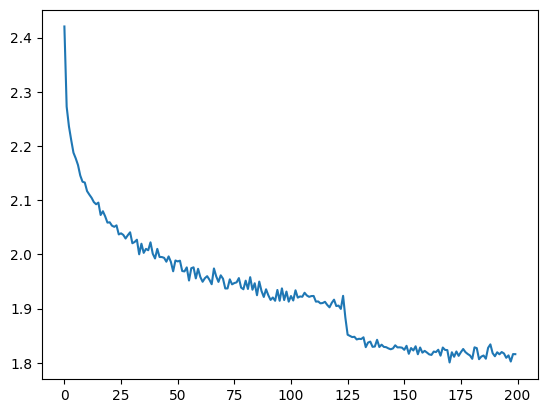

In [365]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [366]:
# to put into eval mode, espeicaly for batch norm
for layer in model.layers:
    layer.training = False

In [367]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

In [368]:
split_loss('train')
split_loss('val')

train 1.7770133018493652
val 1.988756537437439


In [394]:
for _ in range(25):

    out = []
    context = [0] * block_size # all with ...

    while True:

        x = torch.tensor([context])
        x = model(x)
        logits = x
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    
    print(''.join(itoc[i] for i in out))

reahan.
emilian.
joviany.
amari.
jessa.
ashiko.
dashlyn.
zeen.
jahzir.
laitan.
anaiyana.
abdulwaya.
omauri.
olanner.
pojcie.
zianyiah.
knost.
ekenley.
reo.
kazae.
faby.
wylden.
meziko.
ashleigh.
dennadie.
